Preparation

In [1]:
#download packages
!pip install -q unrar jaxwt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import glob
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import jit, vmap
import jaxwt as jwt

In [4]:
!mkdir folders
!tar -xvzf /content/drive/MyDrive/DM_project2/ADHD200_CC400_TCs_filtfix.tar.gz -C folders --exclude templates --exclude extract_tcs.sh

KKI/KKI_phenotypic.csv
NeuroIMAGE/NeuroIMAGE_phenotypic.csv
NYU/NYU_phenotypic.csv
OHSU/OHSU_phenotypic.csv
Peking_1/Peking_1_phenotypic.csv
Peking_2/Peking_2_phenotypic.csv
Peking_3/Peking_3_phenotypic.csv
Pittsburgh/Pittsburgh_phenotypic.csv
WashU/WashU_phenotypic.csv
KKI/KKI_motion.csv
KKI/1018959/sfnwmrda1018959_session_1_rest_1_cc400_TCs.1D
KKI/1018959/snwmrda1018959_session_1_rest_1_cc400_TCs.1D
KKI/1019436/sfnwmrda1019436_session_1_rest_1_cc400_TCs.1D
KKI/1019436/snwmrda1019436_session_1_rest_1_cc400_TCs.1D
KKI/1043241/sfnwmrda1043241_session_1_rest_1_cc400_TCs.1D
KKI/1043241/snwmrda1043241_session_1_rest_1_cc400_TCs.1D
KKI/1266183/sfnwmrda1266183_session_1_rest_1_cc400_TCs.1D
KKI/1266183/snwmrda1266183_session_1_rest_1_cc400_TCs.1D
KKI/1535233/sfnwmrda1535233_session_1_rest_1_cc400_TCs.1D
KKI/1535233/snwmrda1535233_session_1_rest_1_cc400_TCs.1D
KKI/1541812/sfnwmrda1541812_session_1_rest_1_cc400_TCs.1D
KKI/1541812/snwmrda1541812_session_1_rest_1_cc400_TCs.1D
KKI/1577042/sfnwmrda

In [5]:
# Define the main directory
main_dir = 'folders'

# Lists to store file paths and folder paths
file_list = []
folder_list = []

# Traverse through the main directory and all its subdirectories
for root, dirs, files in os.walk(main_dir):
    # Find files matching the pattern sfn*.1D in the current directory
    for file_name in glob.glob(os.path.join(root, 'sfn*.1D')):
        # Append the file path to the file_list
        file_list.append(file_name)
        # Append the folder path to the folder_list
        folder_list.append(root.split("/")[2])

# Print the lists to verify
print("Files:", file_list)
print("Folders:", folder_list)

# Verify that both lists have the same size
assert len(file_list) == len(folder_list), "The lists are not the same size"

Files: ['folders/NYU/1740607/sfnwmrda1740607_session_1_rest_2_cc400_TCs.1D', 'folders/NYU/1740607/sfnwmrda1740607_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/1875084/sfnwmrda1875084_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/0010002/sfnwmrda0010002_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/0010002/sfnwmrda0010002_session_1_rest_2_cc400_TCs.1D', 'folders/NYU/0010004/sfnwmrda0010004_session_1_rest_2_cc400_TCs.1D', 'folders/NYU/0010004/sfnwmrda0010004_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/4187857/sfnwmrda4187857_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/4187857/sfnwmrda4187857_session_1_rest_2_cc400_TCs.1D', 'folders/NYU/4079254/sfnwmrda4079254_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/4079254/sfnwmrda4079254_session_1_rest_2_cc400_TCs.1D', 'folders/NYU/2991307/sfnwmrda2991307_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/2991307/sfnwmrda2991307_session_1_rest_2_cc400_TCs.1D', 'folders/NYU/0010119/sfnwmrda0010119_session_1_rest_1_cc400_TCs.1D', 'folders/NYU/1497055/sfnwm

In [6]:
dataframes = []
root = "/content/folders"
for dir in os.listdir(root):
    dirpath = os.path.join(root, dir)
    for filename in glob.glob1(dirpath, '*_phenotypic.csv'):
        filepath = os.path.join(dirpath, filename)
        df = pd.read_csv(filepath)

        try:
          df = df.loc[:,["ScanDir ID", "DX"]]
        except:
          df.rename(columns={"ScanDirID": "ScanDir ID"}, inplace=True)
          try:
            df = df.loc[:,["ScanDir ID", "DX"]]
          except:
            print("The file \'%s\' does not have ScanDir ID or DX columns"%filepath)

        # Check for NaN values
        if df.isnull().values.any():
            print("The file \'%s\' has nan values"%filepath)

        dataframes.append(df)

diagnosis_df = pd.concat(dataframes, ignore_index=True)

Verify that all dignosis for all records are available.

In [7]:
ScanDirIDs = diagnosis_df["ScanDir ID"].tolist()
assert len(
    set(map(int, folder_list))-set(ScanDirIDs)
  ) == 0




assert that each data file has the same number of measured points

In [8]:
columns_Set = pd.read_csv(file_list[0], sep="\t").drop(["File", "Sub-brick"], axis=1).columns
columns_Set = set(columns_Set.tolist())
for file in file_list:
    df = pd.read_csv(file, sep="\t").drop(["File", "Sub-brick"], axis=1)
    assert columns_Set == set(df.columns.tolist())

extract correlation among different point in each data file and aggregate them all

In [9]:
def optimized_jax_code(file_list, name2save, distance, diagnosis_df):
    results_list = []

    for file_path in file_list:

        df = pd.read_csv(file_path, sep="\t").drop(["File", "Sub-brick"], axis=1)
        columns = df.columns

        # Convert the dataframe to a JAX array
        data = jnp.array(df.values)

        # Generate all combinations of i and j for upper triangle
        i_indices, j_indices = jnp.triu_indices(351, k=1)


        # Vectorize the calculation over all combinations
        calc_adjacency_batched = vmap(lambda i, j: distance(data[:, i], data[:, j]))

        values = calc_adjacency_batched(i_indices, j_indices)

        # Convert JAX array to numpy array for DataFrame insertion
        upper_triangle_values = jnp.array(values)

        # Convert to a numpy array and append the filename at the beginning
        results_list.append([file_path] + upper_triangle_values.tolist())


    # Convert the list of arrays to a DataFrame
    results_df = pd.DataFrame(results_list, columns=["File"] + [f"Value_{i}" for i in range(upper_triangle_values.shape[0])])

    ###### Add corresponding diagnosis to the dataframe

    # Extract the ID from the 'File' column in diagnosis df
    results_df['Extracted ID'] = results_df['File'].apply(lambda x: int(x.split('/')[2]))

    # Merge results_df with labels on the extracted ID and 'ScanDir ID'
    results_df = results_df.merge(diagnosis_df, how='left', left_on='Extracted ID', right_on='ScanDir ID')

    # Drop Extracted ID column
    results_df.drop("Extracted ID", axis=1, inplace=True)

    # Save the DataFrame to a file if needed
    results_df.to_csv("/content/drive/MyDrive/DM_project2/full_"+name2save+".csv", index=False)

Pearsonr calculation

In [ ]:
@jit
def pearsonr(x, y):
    x_diff = x - jnp.mean(x)
    y_diff = y - jnp.mean(y)
    numerator = jnp.sum(x_diff * y_diff)
    denominator = jnp.sqrt(jnp.sum(x_diff ** 2) * jnp.sum(y_diff ** 2))
    return numerator / denominator

In [ ]:
optimized_jax_code(file_list, "pearsonr", pearsonr, diagnosis_df)

*educian distance*

In [ ]:
@jit
def educian(x, y):
  return jnp.sqrt(
      jnp.sum((x - y)**2)
      )

In [ ]:
optimized_jax_code(file_list, "educian", educian, diagnosis_df)

Cosine Similiarity

In [ ]:
@jit
def cosine_similarity(x, y):
    x_normalized = x / jnp.linalg.norm(x)
    y_normalized = y / jnp.linalg.norm(y)
    return jnp.dot(x_normalized, y_normalized)

In [ ]:
optimized_jax_code(file_list, "cosine_similarity", cosine_similarity, diagnosis_df)

Wavelet

In [10]:
def wavelet(x,y):
  wavelet = 'db1'
  coeffs_x = jwt.wavedec(x, wavelet)
  coeffs_y = jwt.wavedec(y, wavelet)

  # Flatten the coefficients for comparison
  flattened_coeffs_x = jnp.hstack(coeffs_x)
  flattened_coeffs_y = jnp.hstack(coeffs_y)

  # Compute the Euclidean distance between the wavelet coefficients
  return jnp.linalg.norm(flattened_coeffs_x - flattened_coeffs_y)

In [13]:
optimized_jax_code(file_list, "wavelet", wavelet, diagnosis_df)

# tmp

```
# This is formatted as code
```



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DM_project2/pearsonr.csv")

In [ ]:
df.head(5)

,File,Value_0,Value_1,Value_2,Value_3,Value_4,Value_5,Value_6,Value_7,Value_8,...,Value_61417,Value_61418,Value_61419,Value_61420,Value_61421,Value_61422,Value_61423,Value_61424,ScanDir ID,DX
0,OHSU/5302451/sfnwmrda5302451_session_1_rest_2_...,0.170279,-0.357015,-0.080553,-0.199137,0.119070,-0.248556,0.203942,0.076475,-0.307579,...,0.136859,-0.184122,-0.023628,-0.182656,0.422924,0.417393,0.085780,-0.137589,5302451,3
1,OHSU/5302451/sfnwmrda5302451_session_1_rest_1_...,0.152777,-0.136541,-0.468412,0.407092,-0.279483,0.206026,0.288624,-0.424829,0.358432,...,0.251784,0.106533,-0.381012,-0.026503,0.225992,0.043158,-0.376233,-0.259121,5302451,3
2,OHSU/5302451/sfnwmrda5302451_session_1_rest_3_...,0.061339,0.142587,-0.375562,0.138847,0.403348,0.030845,0.201648,-0.463963,0.018966,...,0.137037,0.224028,-0.127067,-0.224240,0.568172,0.055972,-0.208200,0.270946,5302451,3
3,OHSU/1664335/sfnwmrda1664335_session_1_rest_1_...,0.234164,-0.390832,-0.042897,-0.287525,-0.369005,-0.463240,0.423153,-0.118169,-0.444646,...,0.479615,-0.255209,0.337163,0.331695,0.048842,-0.154432,0.260931,-0.267054,1664335,0
4,OHSU/1664335/sfnwmrda1664335_session_1_rest_3_...,-0.035030,-0.404082,-0.266019,-0.054554,-0.198482,-0.117396,0.011500,-0.339786,0.053622,...,0.484171,-0.157476,-0.251803,-0.369669,0.149649,0.437400,-0.585795,-0.240531,1664335,0


In [ ]:
all_data = df.iloc[:, 1:-2].to_numpy()
global_mean = np.mean(all_data)
print("global mean", global_mean)
global_std = np.std(all_data)
print('global std', global_std)

global mean 0.007687684879523728
global std 0.31713751665820733


In [ ]:
threshold_max = global_mean+3*global_std
print(threshold_max)
threshold_min = global_mean-3*global_std
print(threshold_min)

0.9591002348541458
-0.9437248650950982


In [ ]:
for j in range(10):
  print(df.iloc[3*j+i, -1])
  for i in range(3):

    data = df.iloc[3*j+i,1:-2].to_numpy()
    print(sum(data >threshold_max), sum(data <threshold_min))
  print("--------------")

3
1 0
0 0
0 0
--------------
0
5 0
2 0
1 0
--------------
0
2 0
3 0
2 0
--------------
3
3 0
23 0
2 0
--------------
0
4 0
28 2
5 0
--------------
1
16 1
2 0
3 0
--------------
1
0 0
7 0
4 0
--------------
0
0 0
2 0
3 0
--------------
3
1 0
0 0
0 0
--------------
0
1 0
6 0
1 0
--------------


In [ ]:
for j in range(10):
  print(df.iloc[3*j+i, -1])
  for i in range(3):

    data = df.iloc[3*j+i,1:-2].to_numpy()
    m = np.mean(data)
    s = np.std(data)
    #print(m, s)
    print(sum(data > m+3*s), sum(data < m-3*s))
  print("--------------")

3
47 0
33 0
71 1
--------------
0
18 0
0 0
6 0
--------------
0
58 0
133 1
41 0
--------------
3
2 0
0 0
0 0
--------------
0
0 0
0 0
0 0
--------------
1
0 0
9 0
0 0
--------------
1
49 0
4 0
0 0
--------------
0
42 0
1 0
0 0
--------------
3
0 0
7 0
47 0
--------------
0
37 0
23 0
29 0
--------------


<Axes: >

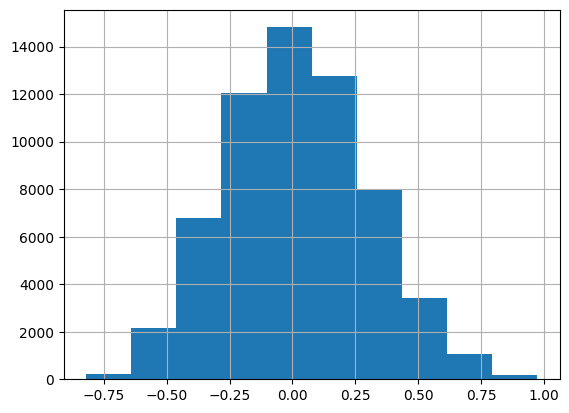

In [ ]:
df.iloc[0,1:-2].hist()

<Axes: >

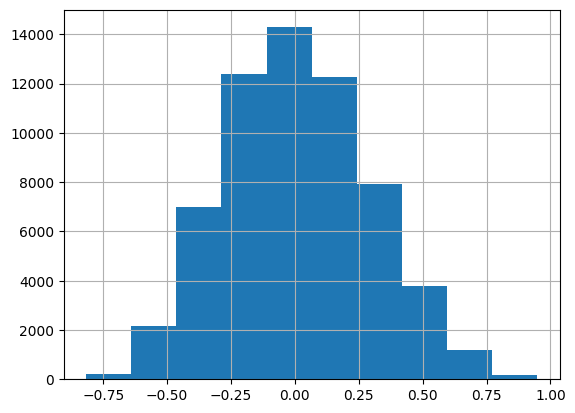

In [ ]:
df.iloc[1,1:-2].hist()

<Axes: >

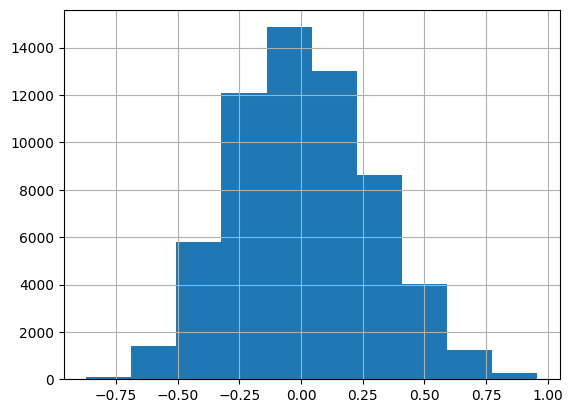

In [ ]:
df.iloc[2,1:-2].hist()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DM_project2/educian.csv")

In [ ]:
for j in range(5):
  print(df.iloc[3*j+i, -1])
  for i in range(3):

    data = df.iloc[3*j+i,1:-2].to_numpy()
    m = np.mean(data)
    s = np.std(data)
    #print(m, s)
    print(sum(data > m+3*s), sum(data < m-3*s))
  print("--------------")

3
797 0
633 0
373 0
--------------
0
778 0
754 0
759 0
--------------
0
501 0
752 0
581 0
--------------
3
299 0
267 0
557 0
--------------
0
512 0
565 0
299 0
--------------


In [ ]:
  pd.read_csv(file_list[0], sep="\t").drop(["File", "Sub-brick"],axis=1)

,Mean_1,Mean_3,Mean_4,Mean_6,Mean_7,Mean_8,Mean_9,Mean_11,Mean_12,Mean_13,...,Mean_391,Mean_392,Mean_393,Mean_394,Mean_395,Mean_396,Mean_397,Mean_398,Mean_399,Mean_400
0,-1.554279,1.574947,-3.985567,-2.355759,1.359929,-1.955401,0.999875,-0.224831,0.608073,1.683511,...,0.595491,1.921428,1.217949,1.248748,-0.711004,-1.354675,-1.847360,0.089654,0.184028,-0.380951
1,-3.247538,1.598731,-3.533667,-1.568304,0.938296,-4.871219,0.707447,-1.609770,2.089430,2.568285,...,2.021726,1.776862,2.006894,-0.514185,-0.631582,-2.441163,-3.511931,0.736833,0.829865,-0.572312
2,-3.608621,-1.021065,-1.549515,0.527404,-0.735611,-7.058289,0.080389,-3.104942,3.726033,2.371317,...,2.590303,0.696348,1.073705,-2.844369,-0.627313,-3.106838,-3.042553,1.889724,1.224793,-0.700987
3,-2.131581,-4.302170,0.258861,1.831999,-2.048251,-7.419671,-0.088314,-3.712685,4.642759,1.469160,...,1.893283,-0.269442,-0.187382,-4.127755,-0.398987,-2.984743,-1.126335,2.295502,0.960841,-0.820136
4,0.238994,-4.992789,0.849880,1.112012,-1.513726,-5.952585,0.431617,-2.898736,4.344797,1.000726,...,0.886188,-0.200997,0.206426,-3.329718,0.324611,-1.938403,-0.183853,1.050726,0.337326,-0.873455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.261913,-1.422978,-2.283012,4.536111,-0.850491,-1.253381,-0.474396,0.448514,0.254904,-1.606578,...,-1.181513,-1.743127,-0.290981,-1.092487,0.472038,-1.628133,3.592158,-0.482530,0.120438,0.158408
70,0.145700,0.282426,0.764286,2.349602,0.072621,1.008247,-0.711461,0.312257,-0.418461,-0.981921,...,-1.188849,-1.925817,2.251275,-0.707056,1.991800,-0.208715,0.817599,-0.973995,0.191008,0.473185
71,0.622533,1.423528,3.320111,1.181662,-0.062109,2.358378,-0.977951,0.855848,-0.520847,0.431484,...,-0.840848,-1.501306,3.298098,0.196656,1.748640,1.253146,-1.238804,-1.372238,-0.181477,0.639186
72,1.357385,1.174602,3.638588,1.254557,-0.928052,2.445861,-0.745198,1.307902,-0.064391,1.329584,...,-0.484738,-0.601113,2.255462,1.287825,-0.136814,1.461161,-1.420562,-1.360102,-0.729627,0.461411


<PjitFunction of <function calc_adjacency at 0x7e95837c3250>>
[ 0.32462823 -0.3392743  -0.15309587 ...  0.19748054 -0.1544404
 -0.15041305]
<PjitFunction of <function calc_adjacency at 0x7e95837c3250>>
[ 0.5351161  -0.5669186  -0.19713168 ... -0.16777426  0.00765591
  0.02082487]
<PjitFunction of <function calc_adjacency at 0x7e95837c3250>>
[ 0.36522475 -0.19545332 -0.5364525  ... -0.06707575  0.52376556
 -0.11990517]
<PjitFunction of <function calc_adjacency at 0x7e95837c3250>>
[-0.0917967   0.32476273 -0.5348068  ... -0.08800047  0.3769363
 -0.30076793]
<PjitFunction of <function calc_adjacency at 0x7e95837c3250>>
[ 0.06549028 -0.17558455 -0.12929612 ... -0.2756971   0.05293383
 -0.05470859]
<PjitFunction of <function calc_adjacency at 0x7e95837c3250>>
[-0.05225328  0.16942833 -0.41606683 ... -0.1496645  -0.18038757
  0.2308965 ]
<PjitFunction of <function calc_adjacency at 0x7e95837c3250>>
[ 0.12516952 -0.3628856  -0.5359736  ...  0.3154065   0.3040113
 -0.2451017 ]
<PjitFunction of

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv("adjacency_matrices.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,61415,61416,61417,61418,61419,61420,61421,61422,61423,61424
0,0.324628,-0.339274,-0.153096,-0.121572,0.233963,-0.248672,0.268984,-0.485591,0.004497,0.141765,...,-0.212875,-0.133076,0.141702,-0.030807,-0.163622,-0.366553,0.269425,0.197481,-0.154440,-0.150413
1,0.535116,-0.566919,-0.197132,-0.021169,-0.037054,-0.420609,0.211597,-0.330135,-0.020001,-0.359300,...,0.368829,0.026694,0.406376,-0.231794,0.204586,0.527768,-0.388838,-0.167774,0.007656,0.020825
2,0.365225,-0.195453,-0.536452,0.363535,0.008705,-0.302721,0.026209,-0.324173,-0.302145,-0.159385,...,-0.263408,-0.628755,0.336442,-0.381805,0.554389,0.273994,0.258972,-0.067076,0.523766,-0.119905
3,-0.091797,0.324763,-0.534807,-0.205664,-0.186474,0.119516,0.084979,0.170208,-0.008323,-0.631130,...,-0.157648,0.022598,0.087999,-0.004375,0.080809,-0.016504,0.023563,-0.088000,0.376936,-0.300768
4,0.065490,-0.175585,-0.129296,-0.097232,-0.101312,-0.345361,-0.040240,0.324977,-0.062001,-0.196010,...,0.023157,-0.096798,0.326150,-0.236892,-0.464934,0.169408,0.059195,-0.275697,0.052934,-0.054709


In [ ]:
print(file_list[0])

OHSU/2232376/sfnwmrda2232376_session_1_rest_2_cc400_TCs.1D


In [ ]:
i_indices, j_indices = jnp.triu_indices(5, k=1)


In [ ]:
i_indices

Array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3], dtype=int32)

In [ ]:
j_indices






Array([1, 2, 3, 4, 2, 3, 4, 3, 4, 4], dtype=int32)